In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

In [18]:
def MC_estimator_h2(pi, X, a, sigma, sample_size):
    '''
    Estimate for E[\pi(X0)] where X0 = (sigma*Z + X)/a and Z starndar normal 
    Parameter:
        pi (funtion): (M, L, N) -> (M, L, 1)
        X  (array):   (L, N)
        a  (Float)
        sigma (Float)
        Sample_size (int)

    return:
        np.array (L,)
    '''
    batch_size = X.shape[0]
    dim_X = X.shape[1]
    Z = np.random.randn(sample_size, batch_size, dim_X)
    X0 = (sigma * Z + X)/a
    # Aplicar pi em X0
    pi_X0 = pi(X0)
    MC = np.mean(pi_X0, axis = 0)
    return MC

def MC_estimator_h1(pi, X, a, sigma, sample_size):
    '''
    Estimate for E[Z \pi(X0)/(sigma)] where X0 = (sigma*Z + X)/a and Z starndar normal 

    Parameter:
        pi (funtion): (M, L, N) -> (M, L, 1)
        X  (array):   (L, N)
        a  (Float)
        sigma (Float)
        Sample_size (int)

    return:
        array:  (L, N)
    '''
    batch_size = X.shape[0]
    dim_X = X.shape[1]
    Z = np.random.randn(sample_size, batch_size, dim_X)
    X0 = (sigma * Z + X)/a
    # Aplicar pi em X0
    pi_X0 = pi(X0)
    pi_X0 = pi_X0
    expression = (Z * pi_X0) / sigma
    MC = np.mean(expression, axis = 0)
    return MC

def beta_funtion(t, bmin = 1.0, bmax = 1.0):
    return bmin + (bmax - bmin)*t

def beta_funtion_integral(t, bmin = 1.0, bmax = 1.0):
    return bmin*t + (bmax - bmin)*(t**2)/2

def compute_a(t, bmin = 1.0, bmax = 1.0):
    beta_integral = beta_funtion_integral(t, bmin = bmin, bmax = bmax)
    return np.exp(- 0.5 * beta_integral) + 1e-5

def compute_sigma(t, bmin = 1.0, bmax = 1.0):
    beta_integral = beta_funtion_integral(t, bmin = bmin, bmax = bmax)
    return np.sqrt(1 - np.exp( - beta_integral)) + 1e-5

def MC_estimator_score(t, X, pi, sample_size, bmin = 1.0, bmax = 1.0, debug = False):
    a = compute_a(t, bmin = bmin, bmax = bmax)
    sigma = compute_sigma(t, bmin = bmin, bmax = bmax)
    h1 = MC_estimator_h1(pi, X, a, sigma, sample_size)
    h2 = MC_estimator_h2(pi, X, a, sigma, sample_size)
    if debug:
        print('a', a)
        print('sigma', sigma)
        print('h1', h1)
        print('h2', h2)
    MC = h1/h2
    return MC

def sample(pi, dim, batch_size, bmin = 1.0, bmax = 1.0, T = 3, N = 1000, sample_size = 30, debug = False):
    X = np.random.normal(size = (batch_size, dim))
    dt = T/N
    for i in range(0, N):
        if debug:
            print(i)
        t = dt * i
        score = MC_estimator_score(T - t, X, pi, sample_size, bmin = bmin, bmax = bmax, debug = debug)
        if debug:
            print('score', score)
            print('X', X)
        beta = beta_funtion(T - t, bmin = bmin, bmax = bmax)
        drift = beta * X / 2 + beta * score
        vol = np.sqrt(beta)
        dW =  np.sqrt(dt)*np.random.normal(size = (batch_size, dim)) 
        X = X + drift*dt + vol*dW
    return X 

In [19]:
def pi_normal(X):
    mean = 0
    var = 1
    density = np.exp(- (X - mean)**2/(2*var))
    return density

C:\Users\henri\AppData\Local\Temp\ipykernel_9628\1571800599.py:72: RuntimeWarning: invalid value encountered in divide
  MC = h1/h2


<Axes: ylabel='Density'>

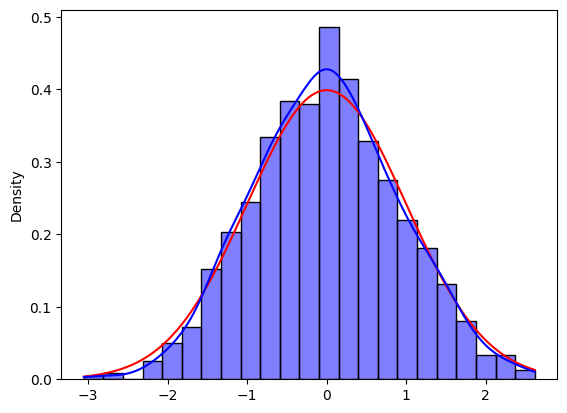

In [28]:
data = sample(pi_normal, 1, 1000, debug=False)[:,0]
x = np.linspace(min(data), max(data), 1000)
y = norm.pdf(x, 0, 1)
plt.plot(x, y, color="red", label="Densidade Normal")
sns.histplot(data, stat = "density", kde = True, color="blue")

In [29]:
def cauchy_distribution(X):
    out = 1 / (1 + X**2)
    return out

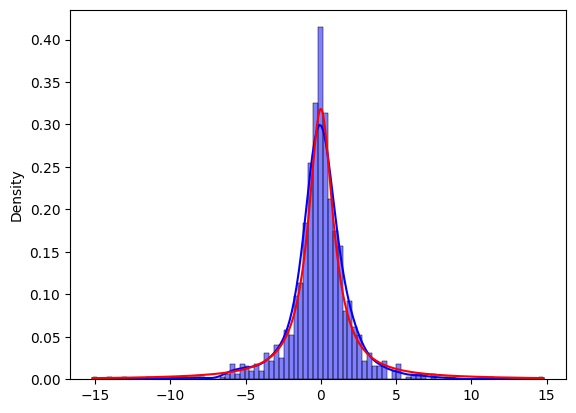

In [32]:
from scipy.stats import cauchy
data = data = sample(cauchy_distribution, 1, 1000, debug=False)[:,0]
x = np.linspace(min(data), max(data), 1000)
y = cauchy.pdf(x, loc=0, scale=1) 
sns.histplot(data, kde=True, stat="density", color="blue", label="Dados Empíricos")
plt.plot(x, y, color="red", label="Densidade Normal")

In [33]:
def pi_normal(X):
    mean = 2
    var = 0.3
    density = np.exp(- (X - mean)**2/(2*var))
    return density

C:\Users\henri\AppData\Local\Temp\ipykernel_9628\1571800599.py:72: RuntimeWarning: invalid value encountered in divide
  MC = h1/h2


<Axes: ylabel='Density'>

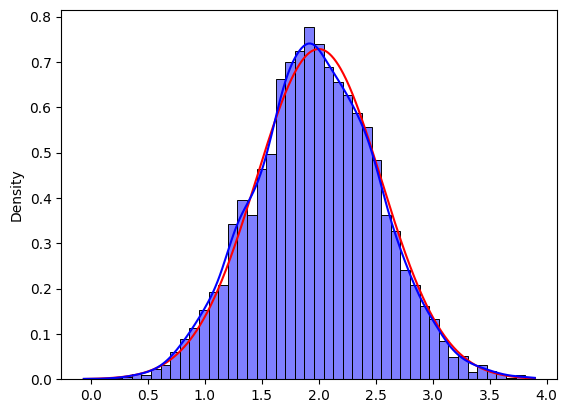

In [38]:
data = sample(pi_normal, 1, 5000, sample_size= 2**8,debug=False)[:,0]
x = np.linspace(min(data), max(data), 1000)
y = norm.pdf(x, 2, np.sqrt(0.3))
plt.plot(x, y, color="red", label="Densidade Normal")
sns.histplot(data, stat = "density", kde = True, color="blue")

In [39]:
def pi_normal(X):
    mean = 0
    var = 1
    density = np.exp(- (X - mean)**2/(2*var))
    return density

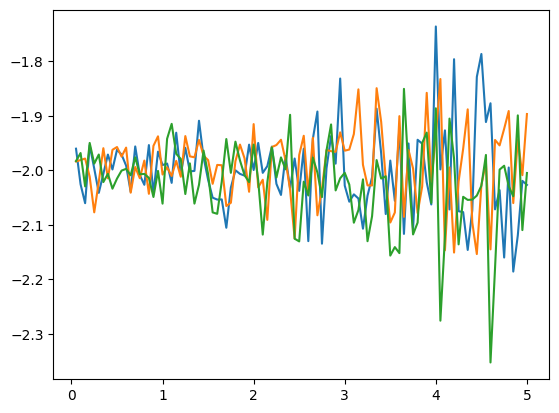

In [40]:
T = 5
N = 100
X = np.array([[2]])
times = [i*T/N for i in range(1, N+1)]
score1 = [MC_estimator_score(t, X, pi_normal, sample_size=2**15)[0,0] for t in times]
score2 = [MC_estimator_score(t, X, pi_normal, sample_size=2**15)[0,0] for t in times]
score3 = [MC_estimator_score(t, X, pi_normal, sample_size=2**15)[0,0] for t in times]
plt.plot(times, score1)
plt.plot(times, score2)
plt.plot(times, score3)

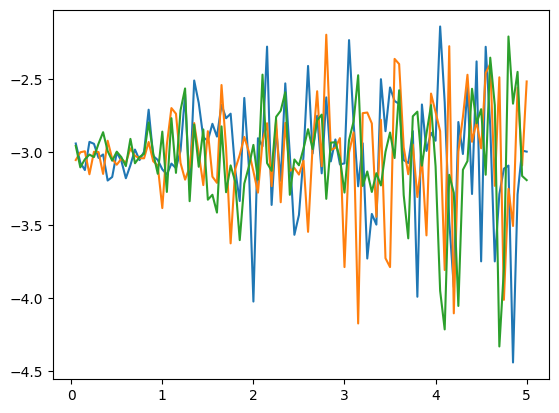

In [42]:
T = 5
N = 100
X = X = np.array([[3]])
times = [i*T/N for i in range(1, N+1)]
score1 = [MC_estimator_score(t, X, pi_normal, sample_size=2**15)[0,0] for t in times]
score2 = [MC_estimator_score(t, X, pi_normal, sample_size=2**15)[0,0] for t in times]
score3 = [MC_estimator_score(t, X, pi_normal, sample_size=2**15)[0,0] for t in times]
plt.plot(times, score1)
plt.plot(times, score2)
plt.plot(times, score3)

In [43]:
def pi_normal(X):
    mu = np.array([2])
    cov = np.array([[0.3]])
    density = np.exp(- (X - mu)**2/(2*cov))
    return density

In [44]:
def compute_exact_score_normal(t, X, mu = 0, var = 1, bmin = 1.0, bmax = 1.0):
    beta_integral = beta_funtion_integral(t, bmin = bmin, bmax = bmax)
    mut = np.exp(- 0.5 * beta_integral)*mu
    vart = 1  + (var - 1)*np.exp( - beta_integral)
    return -(X - mut)/vart

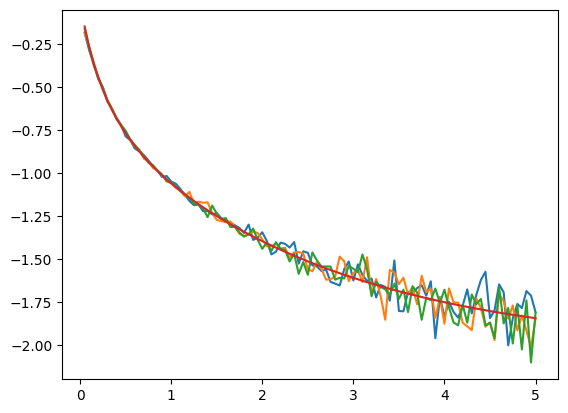

In [49]:
T = 5
N = 100
X = np.array([[2]])
times = [i*T/N for i in range(1, N+1)]
score1 = [MC_estimator_score(t, X, pi_normal, sample_size=2**15)[0,0] for t in times]
score2 = [MC_estimator_score(t, X, pi_normal, sample_size=2**15)[0,0] for t in times]
score3 = [MC_estimator_score(t, X, pi_normal, sample_size=2**15)[0,0] for t in times]
score_exato = [compute_exact_score_normal(t, X[0,:], mu = 2, var = 0.3) for t in times]
plt.plot(times, score1)
plt.plot(times, score2)
plt.plot(times, score3)
plt.plot(times, score_exato)

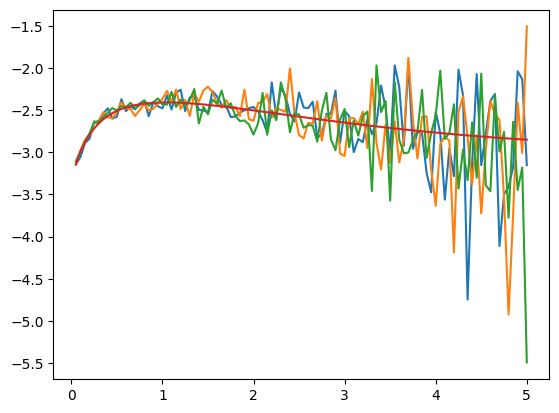

In [50]:
T = 5
N = 100
X = np.array([[3]])
times = [i*T/N for i in range(1, N+1)]
score1 = [MC_estimator_score(t, X, pi_normal, sample_size=2**15)[0,0] for t in times]
score2 = [MC_estimator_score(t, X, pi_normal, sample_size=2**15)[0,0] for t in times]
score3 = [MC_estimator_score(t, X, pi_normal, sample_size=2**15)[0,0] for t in times]
score_exato = [compute_exact_score_normal(t, X[0,:], mu = 2, var = 0.3) for t in times]
plt.plot(times, score1)
plt.plot(times, score2)
plt.plot(times, score3)
plt.plot(times, score_exato)

In [56]:
def gausssian_mixture(X):
    mu1 = 2
    mu2 = -3
    var = 0.3
    componet1 = np.exp(-((X - mu1)**2) / (2*var))
    componet2 = np.exp(-((X - mu2)**2) / (2*var))
    return componet1 + componet2

In [59]:
model_sample = sample(gausssian_mixture, 1, 1000, T = 5, sample_size=2**10, N=4000)

C:\Users\henri\AppData\Local\Temp\ipykernel_9628\1571800599.py:72: RuntimeWarning: invalid value encountered in divide
  MC = h1/h2


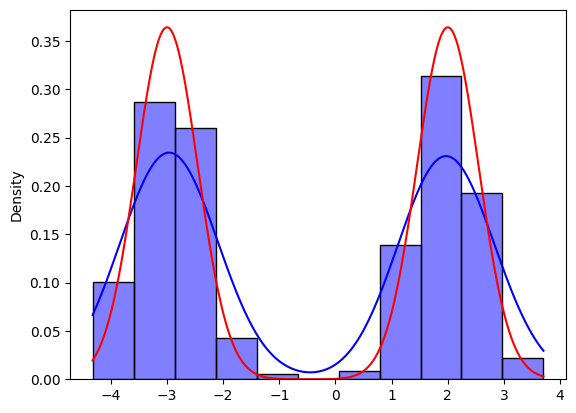

In [60]:
y1 = norm.pdf(x, 2, np.sqrt(0.3))
y2 = norm.pdf(x, -3, np.sqrt(0.3))
y = 0.5 * y1 + 0.5 * y2
data = model_sample[:,0]
x = np.linspace(min(data), max(data), 1000)
y1 = norm.pdf(x, 2, np.sqrt(0.3))
y2 = norm.pdf(x, -3, np.sqrt(0.3))
y = 0.5 * y1 + 0.5 * y2
sns.histplot(data, kde=True, stat="density", color="blue", label="Dados Empíricos")
plt.plot(x, y, color="red", label="Densidade Normal")

In [63]:
def gausssian_mixture_multi(X):
    mu1 = np.array([[[2,2]]])
    mu2 = np.array([[[-2,-2]]])
    var = 0.3

    componet1 = np.exp(-((X - mu1)**2).sum(axis = -1) / (2*var))
    componet2 = np.exp(-((X - mu2)**2).sum(axis = -1) / (2*var))
    dim1 = componet1.shape[0]
    dim2 = componet1.shape[1]
    return (componet1 + componet2).reshape(dim1, dim2, 1)

In [70]:
model_sample = sample(gausssian_mixture_multi, 2, 1000, T = 3, sample_size=2**10, N= 1000)

C:\Users\henri\AppData\Local\Temp\ipykernel_9628\1571800599.py:72: RuntimeWarning: invalid value encountered in divide
  MC = h1/h2


<Axes: >

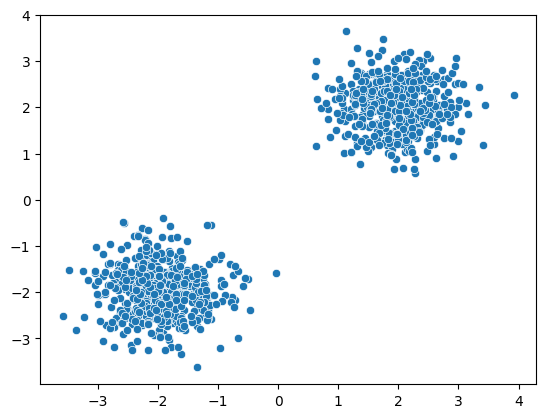

In [71]:
sns.scatterplot(x = model_sample[:, 0], y = model_sample[:,1])

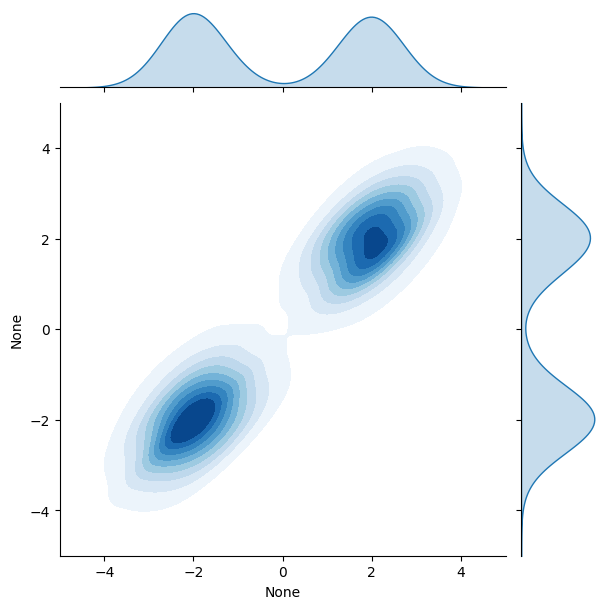

In [105]:
data = np.array(model_sample)
g = sns.jointplot(x = np.array(model_sample)[:, 0], y = np.array(model_sample)[:,1], cmap="Blues", fill=True, kind='kde')
g.ax_joint.set_xlim(-5, 5)
g.ax_joint.set_ylim(-5, 5)
# g.ax_joint.set_aspect("equal", adjustable="datalim")
plt.show()

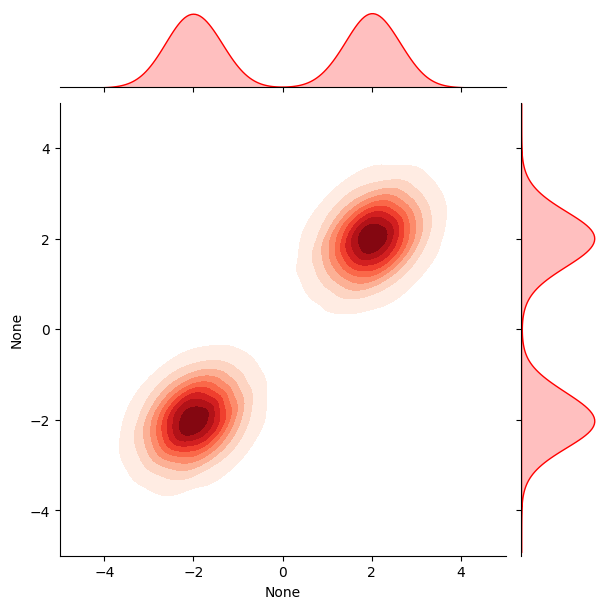

In [102]:
n_p = np.sqrt(0.3)*np.random.randn(10000,2)-2
n_m = np.sqrt(0.3)*np.random.randn(10000,2)+2
exact = np.concat([n_p, n_m])
sns.jointplot(x = exact[:, 0], y = exact[:,1], cmap="Reds", fill=True, kind='kde', marginal_kws={"color": "red"})
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.show()

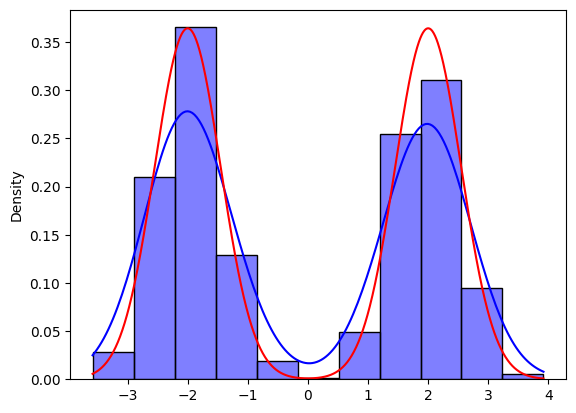

In [73]:
data1 = np.array(model_sample)[:, 0]
data1 = data1[~np.isnan(data1)]
x = np.linspace(min(data1), max(data1), 1000)
y1 = norm.pdf(x, 2, np.sqrt(0.3))
y2 = norm.pdf(x, -2, np.sqrt(0.3))
y = 0.5 * y1 + 0.5 * y2
sns.histplot(data1, kde=True, stat="density", color="blue", label="Dados Empíricos")
plt.plot(x, y, color="red", label="Densidade Normal")

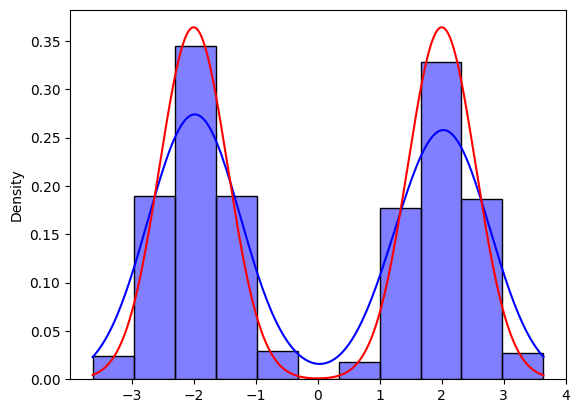

In [74]:
data2 = np.array(model_sample)[:, 1]
data2 = data2[~np.isnan(data2)]
x = np.linspace(min(data2), max(data2), 1000)
y1 = norm.pdf(x, 2, np.sqrt(0.3))
y2 = norm.pdf(x, -2, np.sqrt(0.3))
y = 0.5 * y1 + 0.5 * y2
sns.histplot(data2, kde=True, stat="density", color="blue", label="Dados Empíricos")
plt.plot(x, y, color="red", label="Densidade Normal")

In [87]:
data[~np.isnan(data).any(axis = 1)][:,0].var()

np.float64(4.16867524724136)

In [85]:
np.cov(data[~np.isnan(data).any(axis = 1)].T)

array([[4.17288178, 3.92056055],
       [3.92056055, 4.24965042]])

In [89]:
np.mean(data[~np.isnan(data).any(axis = 1)].T, axis = 1)

array([-0.05044606, -0.0346447 ])

In [103]:
np.cov(exact.T)

array([[4.30257252, 3.99303916],
       [3.99303916, 4.29719548]])